In [1]:
import numpy as np
import matplotlib.pyplot as plt


from hnc import  HNC_solver
from qsps import *


In [2]:
N_bins = 1000

In [3]:
def run_hnc(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, c_s_r_guess=None , method='best'):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri)

    N_species = 2
    Gamma = np.array(  [[qsp.Γii,  qsp.Γei],
                        [qsp.Γei,  qsp.Γee]])


    names = ["Ion-1", "Electron", ] 
    kappa = 1
    rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
    hnc1 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, rho = rho, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=N_bins, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array), qsp.βvei(hnc1.r_array)],
                            [qsp.βvei(hnc1.r_array), qsp.βvee(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    if c_s_r_guess is not None:
        for i in range(N_species):
            for j in range(N_species):
                if (c_s_r_guess[i,j]!=np.zeros(hnc1.N_bins)).all():
                    hnc1.c_s_r_matrix[i,j] = c_s_r_guess[i,j]
                    hnc1.c_s_k_matrix[i,j] = hnc1.FT_r_2_k(c_s_r_guess[i,j])
                    hnc1.c_r_matrix[i,j] = hnc1.c_s_k_matrix[i,j] - hnc1.βu_l_k_matrix[i,j]

    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = 1e-3, alpha_oz = 0e-4, h_max=1e4)
    
    return hnc1, qsp

In [4]:
def run_hnc_one_species(n_in_per_cc, T, Z, A, Zstar, num_iterations=1e3, method='best' ):
    ri = QSP_HNC.rs_from_n(n_in_per_cc*1e6 *aB**3)
    qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri)

    N_species = 1
    Gamma = np.array(  [[qsp.Γii]])


    names = ["Ion-1"] 
    kappa = 1
    rho = np.array([  3/(4*np.pi)])
    hnc1 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-5,
                     kappa_multiscale=1, rho = rho, num_iterations=int(num_iterations), 
                     R_max=5, N_bins=1000, names=names, dst_type=3)

    βu_r_matrix = np.array([[qsp.βvii(hnc1.r_array)]])

    hnc1.set_βu_matrix(βu_r_matrix)
    hnc1.initialize_c_k()
    hnc1.set_C_matrix()
    hnc1.HNC_solve(alpha_method=method, alpha_Picard = 1e-2, alpha_oz = 0e-4, h_max=1e4)
    return hnc1, qsp

# Priority 1
## Carbon

In [14]:
ni = 5.01e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 6,12
Zstar= 3

# c_s_r_guess = np.zeros((2,2,N_bins))
# c_s_r_guess[0,0] = carbon_one_species.c_s_r_matrix

carbon, carbonqsp = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, c_s_r_guess=c_s_r_guess)


Λee = 0.328
Λei = 0.232
Γii=82.957, Γie=-1.499, Γee=0.500 
r_i=1.476
r_e=1.023
θ  =4.18e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
0: Err in c_r: 1.43e+02, OZ: 1.43e-01, HNC: 1.30e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 7.83e+01, OZ: 1.34e-01, HNC: 6.16e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 4.31e+01, OZ: 1.27e-01, HNC: 5.78e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 2.41e+01, OZ: 1.23e-01, HNC: 7.00e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 1.39e+01, OZ: 1.21e-01, HNC: 9.32e-02
 HNC min: [0.5] True Optimization terminated successfully.

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
48: Err in c_r: 1.51e-01, OZ: 4.99e-02, HNC: 3.58e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
49: Err in c_r: 1.45e-01, OZ: 4.86e-02, HNC: 3.51e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
50: Err in c_r: 1.39e-01, OZ: 4.74e-02, HNC: 3.44e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 1.34e-01, OZ: 4.63e-02, HNC: 3.36e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 1.29e-01, OZ: 4.51e-02, HNC: 3.29e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.24e-01, OZ

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
96: Err in c_r: 2.86e-02, OZ: 1.38e-02, HNC: 9.78e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
97: Err in c_r: 2.77e-02, OZ: 1.34e-02, HNC: 9.50e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
98: Err in c_r: 2.69e-02, OZ: 1.30e-02, HNC: 9.22e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
99: Err in c_r: 2.60e-02, OZ: 1.27e-02, HNC: 8.95e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
100: Err in c_r: 2.52e-02, OZ: 1.23e-02, HNC: 8.68e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
101: Err in c_r: 2.44e-02, 

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
144: Err in c_r: 6.58e-03, OZ: 3.50e-03, HNC: 2.30e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
145: Err in c_r: 6.39e-03, OZ: 3.40e-03, HNC: 2.23e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
146: Err in c_r: 6.20e-03, OZ: 3.31e-03, HNC: 2.17e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
147: Err in c_r: 6.02e-03, OZ: 3.21e-03, HNC: 2.11e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
148: Err in c_r: 5.85e-03, OZ: 3.12e-03, HNC: 2.04e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
149: Err in c_r: 5.68e-

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
195: Err in c_r: 1.49e-03, OZ: 8.10e-04, HNC: 5.20e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
196: Err in c_r: 1.45e-03, OZ: 7.87e-04, HNC: 5.05e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
197: Err in c_r: 1.40e-03, OZ: 7.65e-04, HNC: 4.90e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
198: Err in c_r: 1.36e-03, OZ: 7.43e-04, HNC: 4.77e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
199: Err in c_r: 1.33e-03, OZ: 7.22e-04, HNC: 4.63e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
200: Err in c_r: 1.29e-

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
247: Err in c_r: 3.33e-04, OZ: 1.82e-04, HNC: 1.16e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
248: Err in c_r: 3.24e-04, OZ: 1.77e-04, HNC: 1.13e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
249: Err in c_r: 3.15e-04, OZ: 1.72e-04, HNC: 1.10e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
250: Err in c_r: 3.06e-04, OZ: 1.67e-04, HNC: 1.07e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
251: Err in c_r: 2.97e-04, OZ: 1.63e-04, HNC: 1.04e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
252: Err in c_r: 2.89e-

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
297: Err in c_r: 7.94e-05, OZ: 4.35e-05, HNC: 2.77e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
298: Err in c_r: 7.72e-05, OZ: 4.23e-05, HNC: 2.69e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
299: Err in c_r: 7.50e-05, OZ: 4.11e-05, HNC: 2.62e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
300: Err in c_r: 7.29e-05, OZ: 3.99e-05, HNC: 2.54e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
301: Err in c_r: 7.08e-05, OZ: 3.88e-05, HNC: 2.47e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
302: Err in c_r: 6.88e-

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
348: Err in c_r: 1.84e-05, OZ: 1.01e-05, HNC: 6.42e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
349: Err in c_r: 1.79e-05, OZ: 9.80e-06, HNC: 6.24e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
350: Err in c_r: 1.74e-05, OZ: 9.52e-06, HNC: 6.07e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
351: Err in c_r: 1.69e-05, OZ: 9.25e-06, HNC: 5.89e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
352: Err in c_r: 1.64e-05, OZ: 8.99e-06, HNC: 5.73e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
353: Err in c_r: 1.59e-

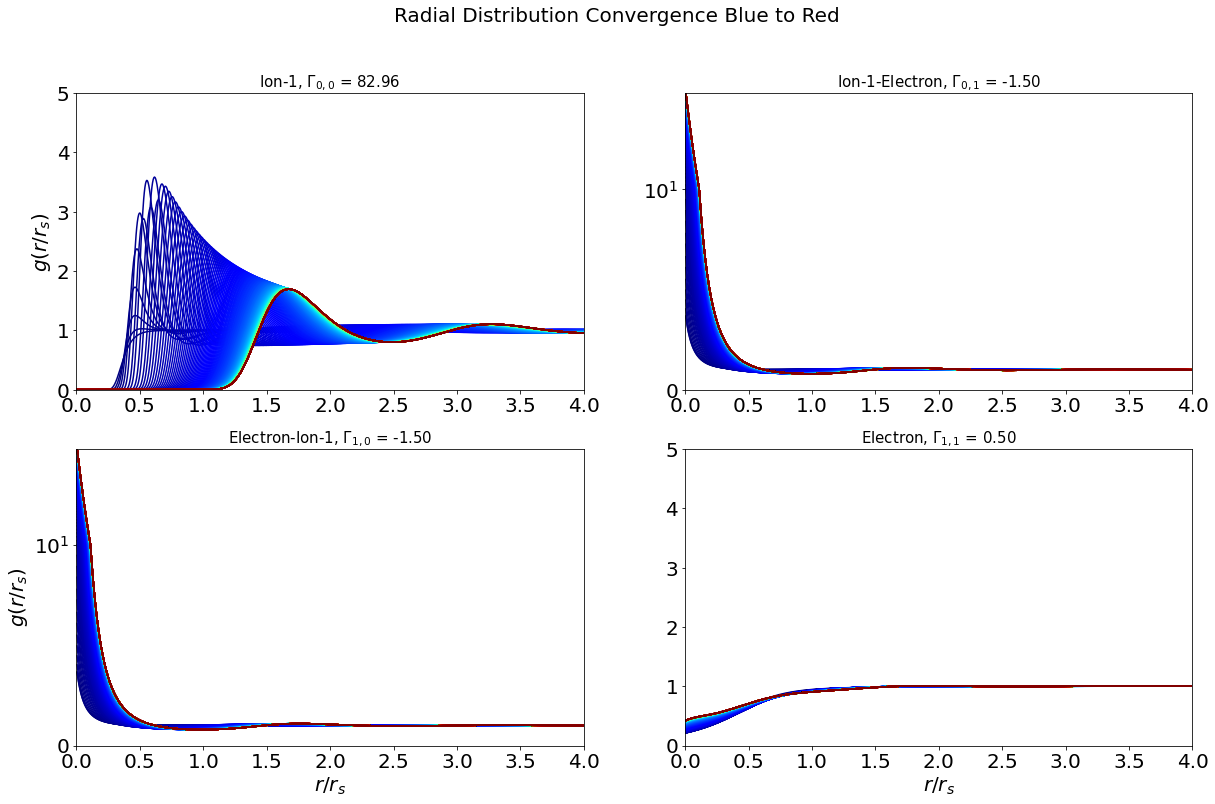

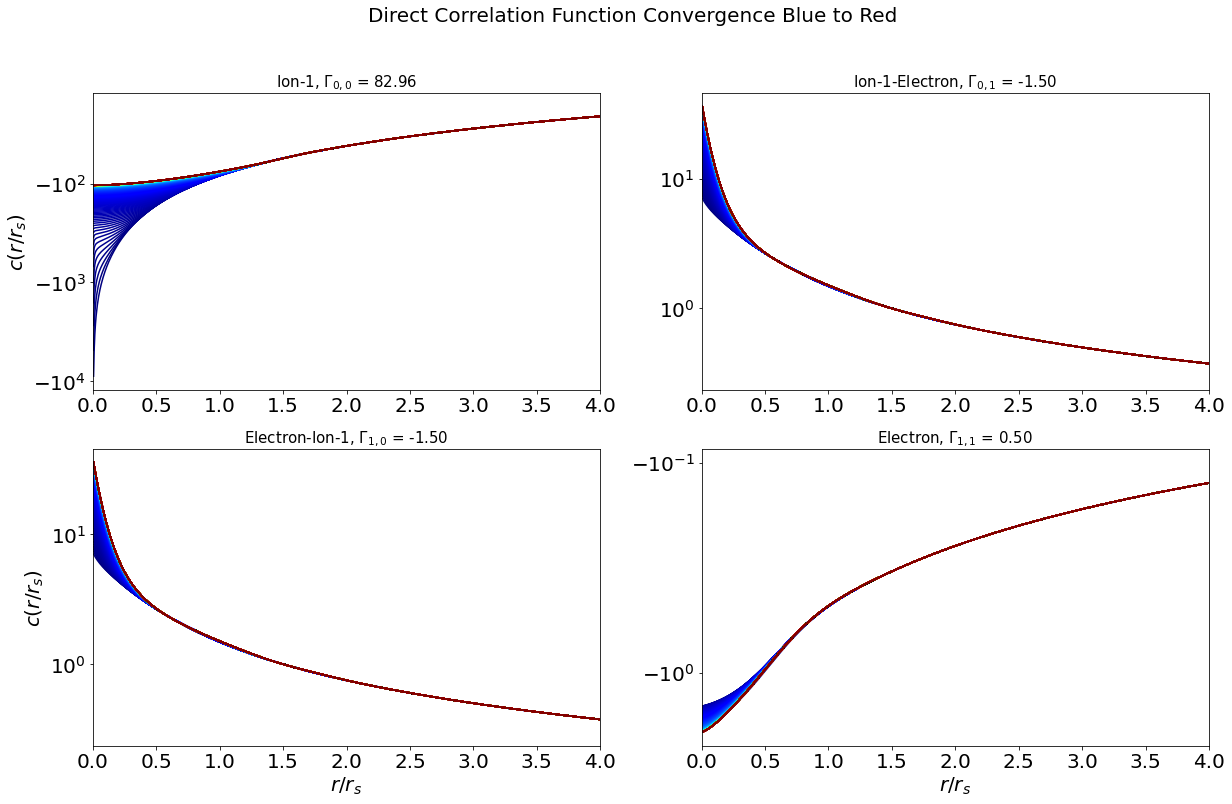

In [15]:
carbon.plot_species_convergence_g(n_slices= int(len(carbon.h_list)/1)  )
carbon.plot_species_convergence_c(n_slices= int(len(carbon.h_list)/1)  )

In [12]:
carbon_one_species, _ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.328
Λei = 0.232
Γii=82.957, Γie=-1.499, Γee=0.500 
r_i=1.476
r_e=1.023
θ  =4.18e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
0: Err in c_r: 2.86e+02, OZ: 2.86e-01, HNC: 1.26e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 1.57e+02, OZ: 2.68e-01, HNC: 6.61e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 8.61e+01, OZ: 2.55e-01, HNC: 5.21e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 4.81e+01, OZ: 2.47e-01, HNC: 1.74e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 2.77e+01, OZ: 2.42e-01, HNC: 6.07e-02
 HNC min: [0.5] True Optimization terminated successfully.

 OZ min:  [0.] True Optimization terminated successfully.
48: Err in c_r: 3.04e-01, OZ: 1.00e-01, HNC: 8.46e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
49: Err in c_r: 2.93e-01, OZ: 9.80e-02, HNC: 8.07e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
50: Err in c_r: 2.81e-01, OZ: 9.56e-02, HNC: 7.70e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 2.71e-01, OZ: 9.33e-02, HNC: 7.36e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.61e-01, OZ: 9.10e-02, HNC: 7.04e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 2.51e-01, OZ: 8.88e-02, HNC: 6.74e-03
 HNC min: [0.5] True Optimization

97: Err in c_r: 5.81e-02, OZ: 2.79e-02, HNC: 1.40e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
98: Err in c_r: 5.63e-02, OZ: 2.71e-02, HNC: 1.36e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
99: Err in c_r: 5.46e-02, OZ: 2.64e-02, HNC: 1.31e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
100: Err in c_r: 5.29e-02, OZ: 2.57e-02, HNC: 1.27e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
101: Err in c_r: 5.13e-02, OZ: 2.50e-02, HNC: 1.23e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
102: Err in c_r: 4.97e-02, OZ: 2.43e-02, HNC: 1.20e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimizat

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
146: Err in c_r: 1.35e-02, OZ: 7.15e-03, HNC: 3.19e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
147: Err in c_r: 1.31e-02, OZ: 6.96e-03, HNC: 3.10e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
148: Err in c_r: 1.27e-02, OZ: 6.77e-03, HNC: 3.01e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
149: Err in c_r: 1.24e-02, OZ: 6.58e-03, HNC: 2.92e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
150: Err in c_r: 1.20e-02, OZ: 6.40e-03, HNC: 2.84e-04
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
151: Err in c_r: 1.17e-

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
197: Err in c_r: 3.18e-03, OZ: 1.73e-03, HNC: 7.44e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
198: Err in c_r: 3.10e-03, OZ: 1.68e-03, HNC: 7.23e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
199: Err in c_r: 3.01e-03, OZ: 1.64e-03, HNC: 7.03e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
200: Err in c_r: 2.93e-03, OZ: 1.59e-03, HNC: 6.84e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
201: Err in c_r: 2.85e-03, OZ: 1.55e-03, HNC: 6.65e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
202: Err in c_r: 2.77e-

250: Err in c_r: 7.26e-04, OZ: 3.96e-04, HNC: 1.69e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
251: Err in c_r: 7.06e-04, OZ: 3.85e-04, HNC: 1.64e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
252: Err in c_r: 6.86e-04, OZ: 3.75e-04, HNC: 1.60e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
253: Err in c_r: 6.68e-04, OZ: 3.64e-04, HNC: 1.55e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
254: Err in c_r: 6.49e-04, OZ: 3.54e-04, HNC: 1.51e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
255: Err in c_r: 6.31e-04, OZ: 3.45e-04, HNC: 1.47e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimi

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
301: Err in c_r: 1.76e-04, OZ: 9.60e-05, HNC: 4.09e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
302: Err in c_r: 1.71e-04, OZ: 9.34e-05, HNC: 3.97e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
303: Err in c_r: 1.66e-04, OZ: 9.08e-05, HNC: 3.86e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
304: Err in c_r: 1.62e-04, OZ: 8.83e-05, HNC: 3.76e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
305: Err in c_r: 1.57e-04, OZ: 8.59e-05, HNC: 3.66e-06
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
306: Err in c_r: 1.53e-

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
355: Err in c_r: 3.92e-05, OZ: 2.14e-05, HNC: 9.11e-07
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
356: Err in c_r: 3.81e-05, OZ: 2.08e-05, HNC: 8.86e-07
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
357: Err in c_r: 3.70e-05, OZ: 2.02e-05, HNC: 8.61e-07
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
358: Err in c_r: 3.60e-05, OZ: 1.97e-05, HNC: 8.38e-07
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
359: Err in c_r: 3.50e-05, OZ: 1.92e-05, HNC: 8.15e-07
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
360: Err in c_r: 3.41e-

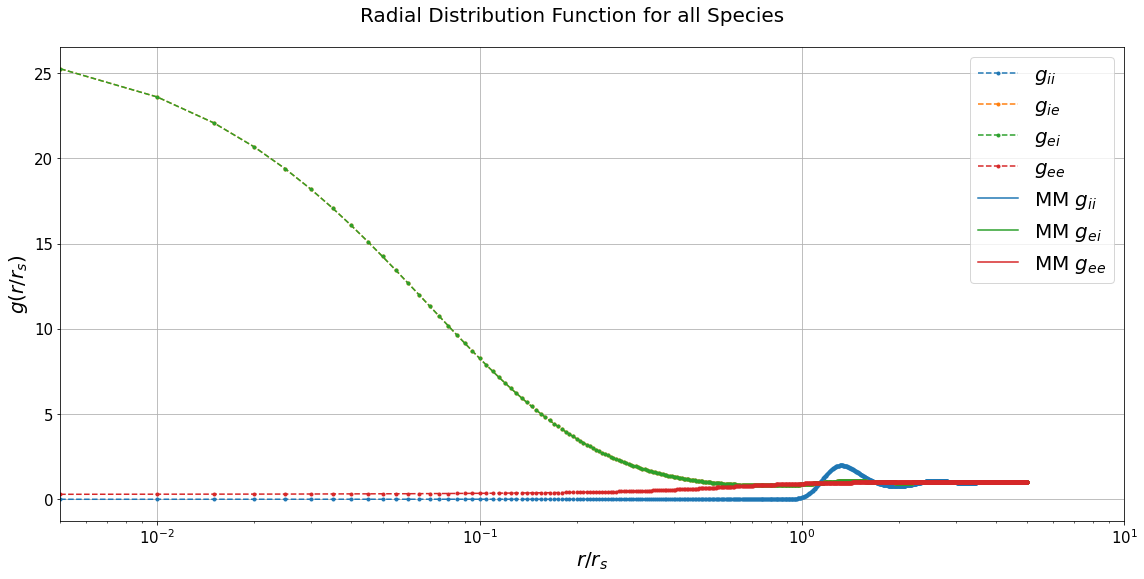

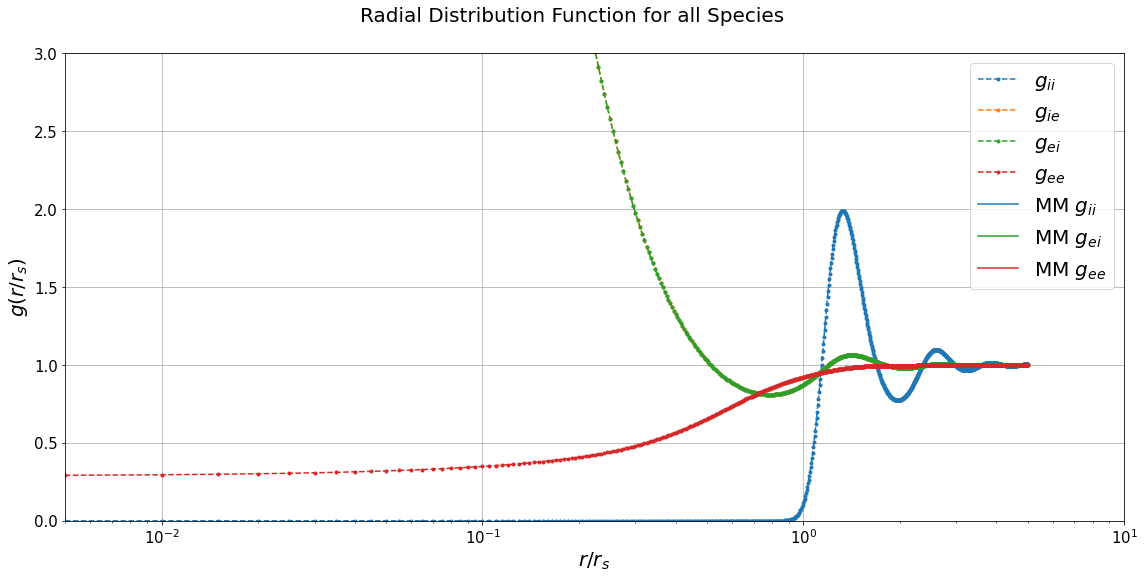

In [10]:
carbon.plot_g_vs_murillo()
carbon.plot_g_vs_murillo(gmax=3)

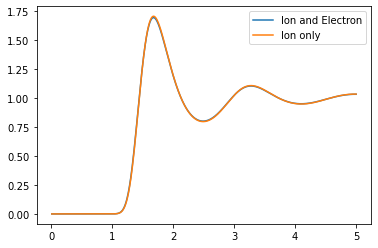

In [16]:
fig, ax = plt.subplots()

ax.plot(carbon.r_array, carbon.h_r_matrix[0,0]+1, label='Ion and Electron')
ax.plot(carbon.r_array, carbon_one_species.h_r_matrix[0,0]+1, label="Ion only")
ax.legend()



## Copper

In [24]:
ni = 8.49e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 29,63.55
Zstar= 1.206


copper,_ = run_hnc(ni, Te, Z, A, Zstar ,num_iterations=1e3, method='best')

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
0: Err in c_r: 2.77e+01, OZ: 8.27e-02, HNC: 1.25e+00
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 1.45e+01, OZ: 7.46e-02, HNC: 4.17e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 7.62e+00, OZ: 6.83e-02, HNC: 4.31e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 4.04e+00, OZ: 6.31e-02, HNC: 5.63e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 2.18e+00, OZ: 5.86e-02, HNC: 7.35e-01
 HNC min: [0.5] True Optimization terminated successfully.

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
48: Err in c_r: 1.35e-03, OZ: 5.65e-04, HNC: 1.01e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
49: Err in c_r: 1.21e-03, OZ: 5.03e-04, HNC: 8.99e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
50: Err in c_r: 1.07e-03, OZ: 4.48e-04, HNC: 8.00e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 9.55e-04, OZ: 3.99e-04, HNC: 7.12e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 8.50e-04, OZ: 3.55e-04, HNC: 6.33e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 7.56e-04, OZ

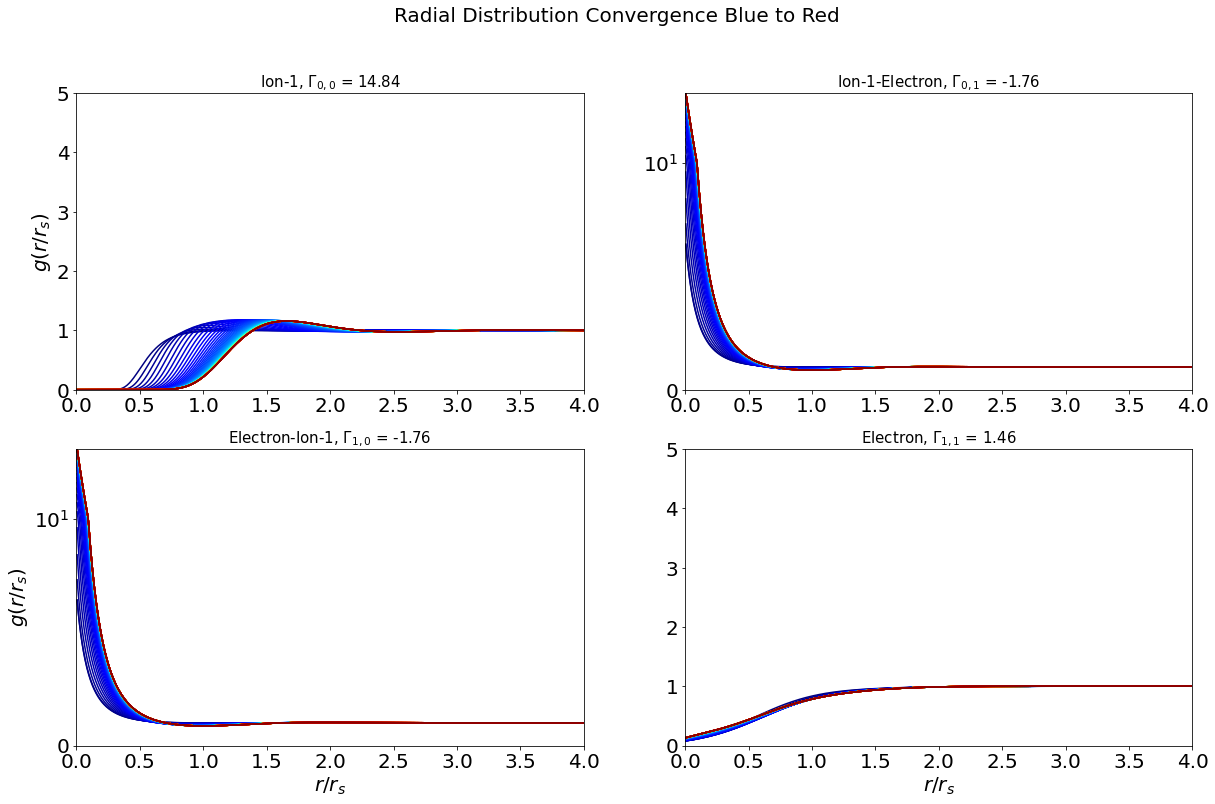

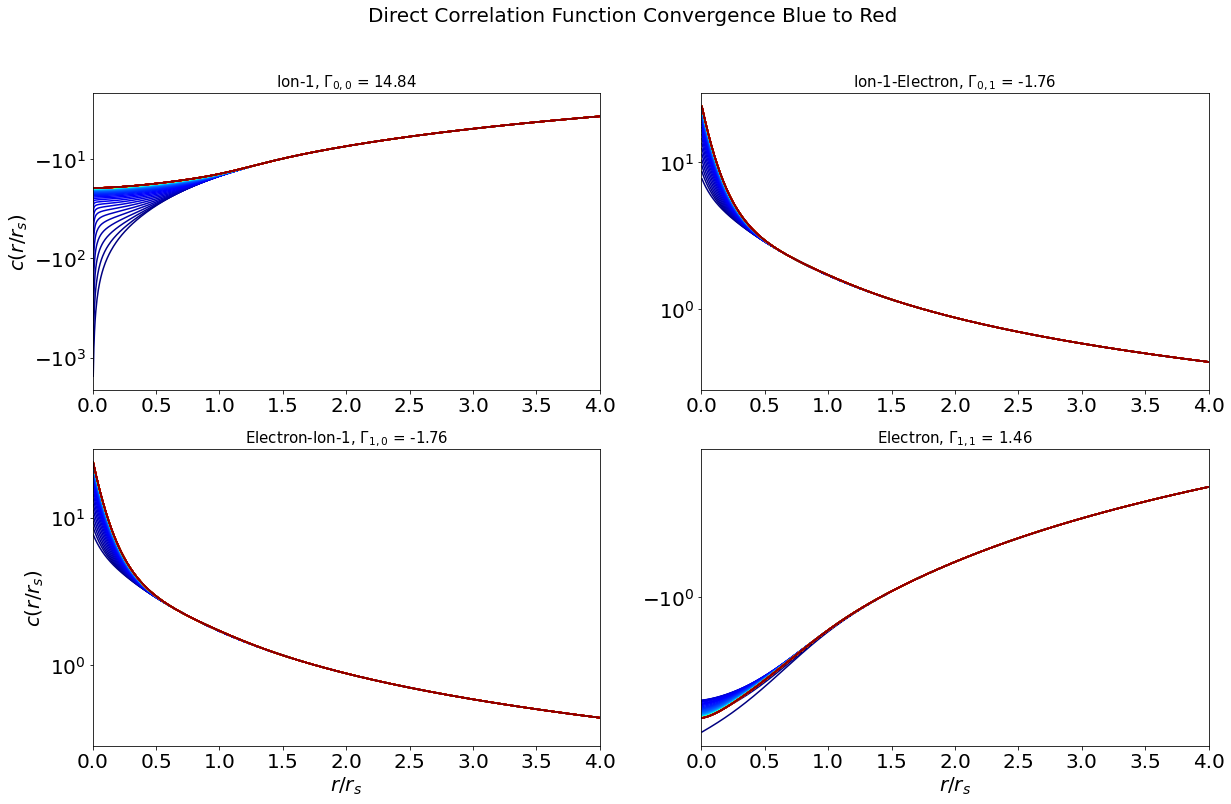

In [25]:
copper.plot_species_convergence_g(n_slices= int(len(copper.h_list)/1)  )
copper.plot_species_convergence_c(n_slices= int(len(copper.h_list)/1)  )

In [26]:
copper_one_species,_ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.417
Λei = 0.295
Γii=14.837, Γie=-1.761, Γee=1.460 
r_i=2.667
r_e=2.506
θ  =1.25e-01
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00313886] True Optimization terminated successfully.
0: Err in c_r: 5.56e+01, OZ: 1.54e-01, HNC: 1.60e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 2.90e+01, OZ: 1.45e-01, HNC: 1.15e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 1.52e+01, OZ: 1.34e-01, HNC: 9.94e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 8.05e+00, OZ: 1.25e-01, HNC: 9.62e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 4.34e+00, OZ: 1.17e-01, HNC: 9.65e-03
 HNC min: [0.5] True Optimization terminated succe

 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.06e-03, OZ: 9.59e-04, HNC: 9.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.85e-03, OZ: 8.61e-04, HNC: 8.72e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.66e-03, OZ: 7.72e-04, HNC: 7.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.49e-03, OZ: 6.93e-04, HNC: 7.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.34e-03, OZ: 6.22e-04, HNC: 6.29e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
57: Err in c_r: 1.20e-03, OZ: 5.58e-04, HNC: 5.65e-05
 HNC min: [0.5] True Optimization

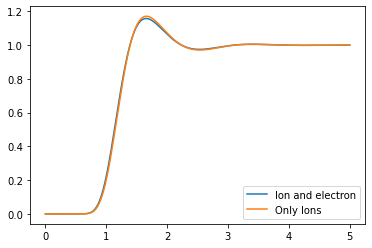

In [27]:
fig, ax = plt.subplots()

ax.plot(copper.r_array, copper.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(copper.r_array, copper_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Hydrogen

In [28]:
ni = 5.98e23 # per cc
Te = 2*eV 
Ti   = 2*eV 
Z, A = 1,1
Zstar= 1
hydrogen, _ = run_hnc(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
0: Err in c_r: 1.85e+01, OZ: 6.96e-02, HNC: 6.19e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
1: Err in c_r: 9.61e+00, OZ: 6.15e-02, HNC: 3.84e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 5.00e+00, OZ: 5.48e-02, HNC: 3.24e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
3: Err in c_r: 2.62e+00, OZ: 4.93e-02, HNC: 3.17e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
4: Err in c_r: 1.39e+00, OZ: 4.44e-02, HNC: 3.22e-02
 HNC min: [0.5] True Optimization terminated successfully.


 OZ min:  [0.] True Optimization terminated successfully.
48: Err in c_r: 2.26e-04, OZ: 9.92e-05, HNC: 8.41e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
49: Err in c_r: 1.95e-04, OZ: 8.57e-05, HNC: 7.26e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
50: Err in c_r: 1.69e-04, OZ: 7.40e-05, HNC: 6.27e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 1.46e-04, OZ: 6.39e-05, HNC: 5.41e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 1.26e-04, OZ: 5.52e-05, HNC: 4.68e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 1.09e-04, OZ: 4.77e-05, HNC: 4.04e-05
 HNC min: [0.5] True Optimization

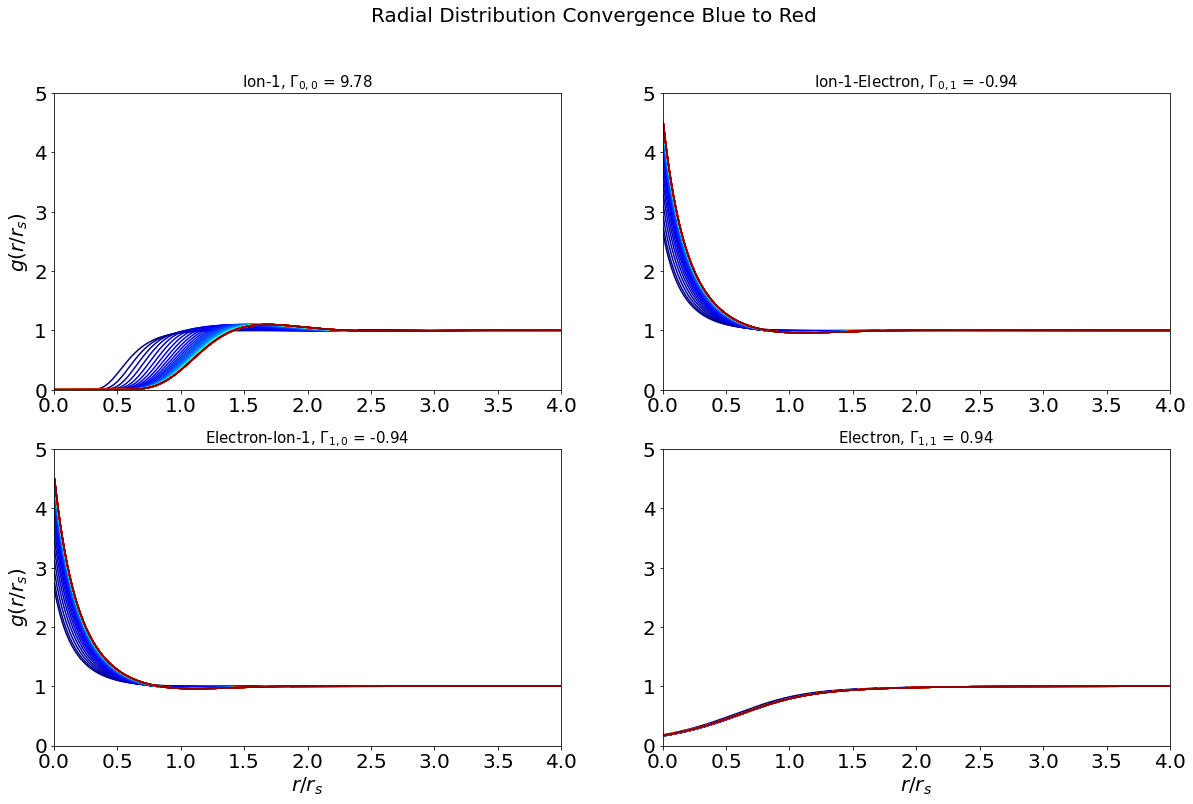

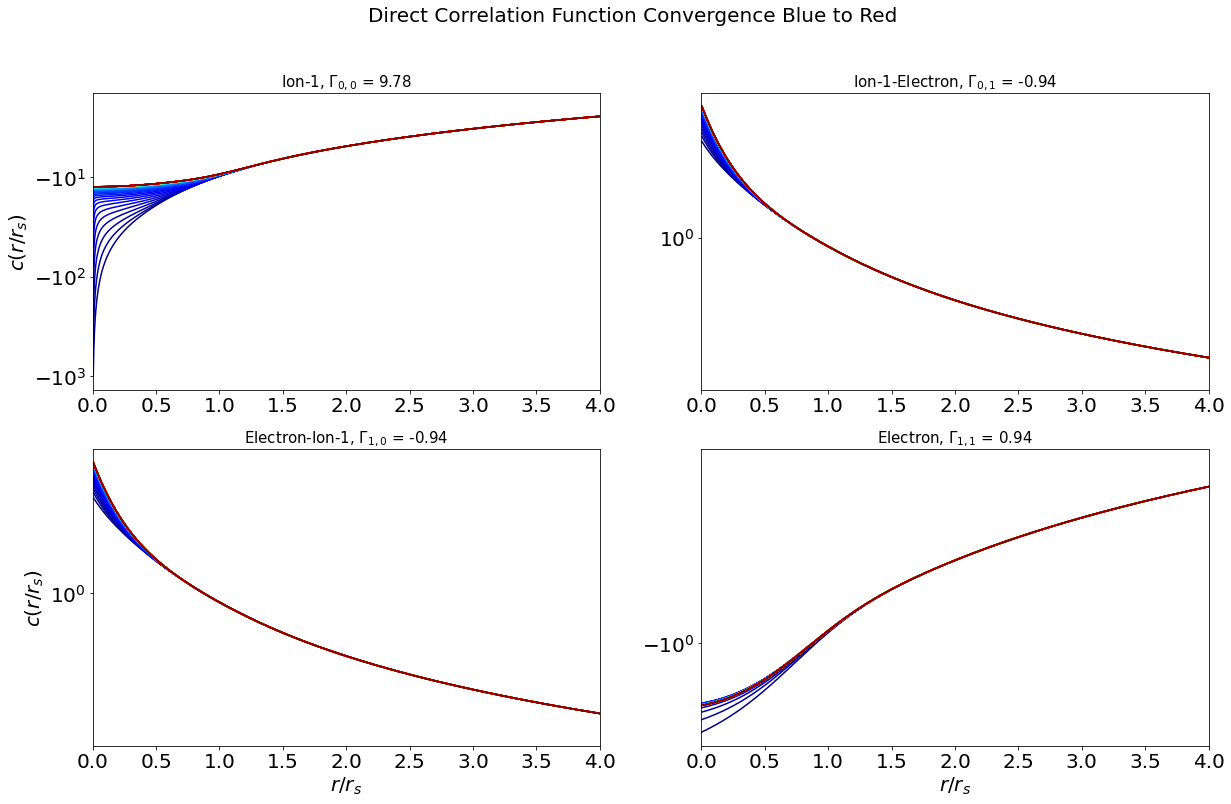

In [29]:
hydrogen.plot_species_convergence_g(n_slices= int(len(hydrogen.h_list)/1)  )
hydrogen.plot_species_convergence_c(n_slices= int(len(hydrogen.h_list)/1)  )

In [30]:
hydrogen_one_species,_ = run_hnc_one_species(ni, Te, Z, A, Zstar )

Λee = 0.465
Λei = 0.329
Γii=9.778, Γie=-0.944, Γee=0.944 
r_i=1.391
r_e=1.391
θ  =7.73e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00622788] True Optimization terminated successfully.
0: Err in c_r: 3.72e+01, OZ: 1.24e-01, HNC: 1.69e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00150465] True Optimization terminated successfully.
1: Err in c_r: 1.91e+01, OZ: 1.14e-01, HNC: 1.22e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
2: Err in c_r: 9.93e+00, OZ: 1.05e-01, HNC: 1.04e-02
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00211755] True Optimization terminated successfully.
3: Err in c_r: 5.22e+00, OZ: 9.06e-02, HNC: 9.42e-03
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.00179066] True Optimization terminated successfully.
4: Err in c_r: 2.77e+00, OZ: 8.08e-02, HNC: 9.05e-03
 HNC min: [0.5] True Optimi

 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
51: Err in c_r: 3.07e-04, OZ: 1.36e-04, HNC: 1.82e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
52: Err in c_r: 2.66e-04, OZ: 1.17e-04, HNC: 1.58e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
53: Err in c_r: 2.30e-04, OZ: 1.02e-04, HNC: 1.37e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
54: Err in c_r: 1.99e-04, OZ: 8.80e-05, HNC: 1.18e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
55: Err in c_r: 1.72e-04, OZ: 7.62e-05, HNC: 1.02e-05
 HNC min: [0.5] True Optimization terminated successfully.
 OZ min:  [0.] True Optimization terminated successfully.
56: Err in c_r: 1.49e-04, OZ

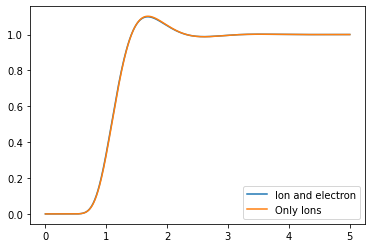

In [31]:
fig, ax = plt.subplots()

ax.plot(hydrogen.r_array, hydrogen.h_r_matrix[0,0]+1, label='Ion and electron')
ax.plot(hydrogen.r_array, hydrogen_one_species.h_r_matrix[0,0]+1, label="Only Ions")
ax.legend()



## Aluminum

In [34]:
ni = 6.03e22 # per cc
Te = 1*eV 
Ti   = 1*eV 
Z, A = 13,27
Zstar= 3
aluminum = run_hnc(ni, Te, Z, A, Zstar, num_iterations=1e3, c_s_r_guess=c_s_r_guess )
# aluminum_i_one_species = run_hnc_one_species(ni, Te, Z, A, Zstar, num_iterations=1e3 )
# aluminum_e_one_species = run_hnc_one_species(Zstar*ni, Te, 1, m_e/m_p, 1, num_iterations=1e3 )


Λee = 0.313
Λei = 0.222
Γii=81.917, Γie=-2.769, Γee=0.923 
r_i=2.989
r_e=2.073
θ  =8.57e-02
 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
0: Err in c_r: 1.33e+00, OZ: 5.46e-01, HNC: inf
 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
1: Err in c_r: 5.64e+00, OZ: 3.55e+00, HNC: inf
 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
2: Err in c_r: 5.39e+01, OZ: 6.51e+02, HNC: inf


/home/zach/plasma/hnc/hnc.py:343: RuntimeWarning: overflow encountered in exp
  self.h_r_matrix = -1 + np.exp(self.γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)


 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
3: Err in c_r: 7.20e+02, OZ: 5.06e+04, HNC: inf
 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
4: Err in c_r: 8.62e+02, OZ: 4.34e+04, HNC: inf
 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
5: Err in c_r: 1.14e+04, OZ: 3.87e+04, HNC: inf
 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
6: Err in c_r: 8.42e+02, OZ: 5.00e+04, HNC: inf
 HNC min: [0.01] False Maximum number of iterations has been exceeded.
 OZ min:  [0.01] False Maximum number of iterations has been exceeded.
7: Err in c_r: 7.16e+02, OZ: 5.43e+04, HNC: inf
 HNC min: [0.01] False Maximum number of iteration

KeyboardInterrupt: 

In [ ]:
aluminum_i_one_species.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum_i_one_species.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )

aluminum_e_one_species.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum_e_one_species.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )

In [ ]:
c_s_r_guess = np.zeros((2,2,N_bins))
c_s_r_guess[0,0] = aluminum_i_one_species.c_s_r_matrix
c_s_r_guess[1,1] = aluminum_e_one_species.c_s_r_matrix

In [ ]:
aluminum = run_hnc(ni, Te, Z, A, Zstar, num_iterations=2, c_s_r_guess=c_s_r_guess )

In [ ]:
aluminum.plot_species_convergence_g(n_slices= int(len(aluminum.h_list)/1)  )
aluminum.plot_species_convergence_c(n_slices= int(len(aluminum.h_list)/1)  )

In [ ]:
aluminum.c_list[-1][1,1]/aluminum.c_list[0][1,1]